# Weight mixing

This is a new kind of method to "train" models super fast without having to retrain the entire model again.

This method, introduced with the development of this mod, requires an overfitted model of your own dataset (in our case, `GPT-Neo-125M` combined with the AWSW data we extracted in step 1) + the pretrained model (`GPT-Neo-125M`).

Weight mixing essentialy involves 3 different steps, and can easily be done on CPU in mere seconds, if you manage to get the pretrained weights in advance:

 1. Generate samples from the base model (the model that came pretrained).
 
 2. Add a small amount of gaussian noise to a variable `s`.
 
 3. Do a linear interpolation between the base model and the main model (our own model) using `s` as a mask.
 
 4. Repeat generating samples on this interpolated model
 
     - Are the samples equal? Repeat from step 2.
     - Is even 1 sample different? Quit and move to step 5 (adding more noise to `s`).
   
 5. Now we have the portion that we know we can adjust without the model giving considerably different results. This is what we call the cold zone.
 
     - Using this new mask, we will linear interpolate between the base model and the main model given a user-specified `amount` and `cold_zone_diffusion_steps`.
     
     - `cold_zone_diffusion_steps` will "spread" noise slightly outside the cold zone by blurring, only affecting places that aren't used yet (i.e all the parts that are 0, the rest remains unchanged). The higher the value, the bigger area it will affect.
     
     - `amount` regulates the amount it'll transition between the main and base model.
    
**Note!** `cold_zone_diffusion_steps` can be skipped when not calling calculate_cold_zones, in this case we just do a simple linear interpolation between the 2 models.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager
from model_mixing import ModelMixing
from model_utils import get_model
from config import Config
import matplotlib.pyplot as plt

In [2]:
saved_model_path = os.path.join("models", "awsw_main")
mixed_model_path = os.path.join("models", "awsw_mixed")
os.makedirs(mixed_model_path, exist_ok=True)
tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
main_model = AutoModelForCausalLM.from_pretrained(saved_model_path)
base_model, _ = get_model("EleutherAI/gpt-neo-125M")
target_model, _ = get_model("EleutherAI/gpt-neo-125M")
device = torch.device('cpu')
target_model.eval()
model_manager = ModelManager(model=target_model, tokenizer=tokenizer, device=device)
model_manager_main = ModelManager(model=main_model, tokenizer=tokenizer, device=device)
print(f"Loaded base and main model to CPU")

Loaded base and main model to CPU


# Initial test
This will mostly be gibberish. This is intentional, as the target model only contains the pre-trained GPT-Neo weights!target_model

In [3]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hello, [player_name]."', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]    
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Fight Adine",
    "Attack Adine"
]

def prompt_test(model_manager, do_sample_test = True):
    for (past, prompt) in prompts:
        print(f"Prompt: {prompt}")
        reply = model_manager.say(past, prompt)
        print(f"Reply: {reply}")
        if do_sample_test:
            reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
            print(f"Reply [sampled]: {reply}")
        print("-" * 10)

def rp_test(model_manager):
    for rp in test_rps:
        print(f'{rp} -> {model_manager.say("", rp, top_k = 50, top_p = 0.7)}')
        print("-" * 10)
    print("Lower case test")
    for rp in test_rps:
        rp = rp[0].lower() + rp[1:]
        print(f'{rp} -> {model_manager.say("", rp)}')
        rp = rp.lower()
        print(f'{rp} -> {model_manager.say("", rp)}')
        print("-" * 10)
        
prompt_test(model_manager_main, do_sample_test = False)

Prompt: How are you?
Reply: park2<msg>Ry "I'm not sure, exactly. It's probably some kind of vegetable blend."<p><msg>c "I see. What kind of meat is commonly eaten around here, anyway?"<d><scn>black<msg>Ry "Aurochs meat. Are you familiar with that animal?"<|endoftext|>
----------
Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "I think he is funny."<|endoftext|>
----------
Prompt: Oh my god, Adine. What is this?
Reply: adineapt<msg>Ad "Well, I'm not going to tell you. Do you want me to put it on or not?"<|endoftext|>
----------
Prompt: What will we do here?
Reply: facin2<msg>An "I don't know where you are going, but I think I need a coffee or five. You can tag along if you like."<p><msg>c "I think I'd rather not."<d><scn>facin2<msg>An "Suit yourself."<d><scn>facin2<msg>n "Whatever the reason, I decided not to join her
----------


In [4]:
def generate_cold_zone_loss_responses(model_manager):
    for (past, prompt) in prompts:
        yield model_manager.say(past, prompt)
    for rp in test_rps:
        yield model_manager.say("", rp)
        rp = rp[0].lower() + rp[1:]
        yield model_manager.say("", rp)
        rp = rp.lower()
        yield model_manager.say("", rp)

original_target_model_responses = list(generate_cold_zone_loss_responses(model_manager_main))
def cold_zone_loss() -> bool:
    new_responses = generate_cold_zone_loss_responses(model_manager)
    for r1, r2 in zip(original_target_model_responses, new_responses):
        if not r1 == r2:
            print(f"Not correct:\nOriginal: {r1}\nv.s\nNew: {r2}\n{'-' * 10}")
            return False
        return True

In [5]:
model_mixing = ModelMixing(tokenizer, base_model, main_model, target_model, seed = 46, cold_zone_loss = cold_zone_loss)

# Testing cold zone diffusion

Cold zone diffusion is mission-critical in determining where to mix models. It's gotta work well.

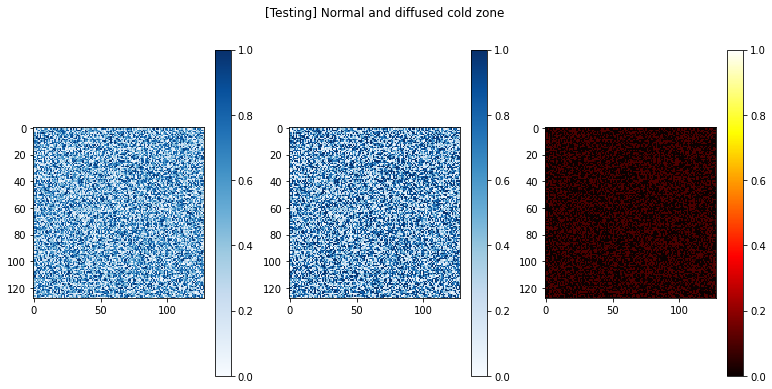

In [6]:
test_cold_zone = np.random.rand(128, 128)
test_cold_zone = torch.Tensor(test_cold_zone)
diffused_cold_zone = model_mixing.diffuse_cold_zone(test_cold_zone, upper_bound = 0.5, diffusion = 0.1)
fig, axs = plt.subplots(figsize=(13, 6), ncols=3)
fig.suptitle('[Testing] Normal and diffused cold zone')
pos = axs[0].imshow(test_cold_zone, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
fig.colorbar(pos, ax=axs[0])
pos = axs[1].imshow(diffused_cold_zone, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
fig.colorbar(pos, ax=axs[1])
pos = axs[2].imshow(abs(diffused_cold_zone - test_cold_zone), cmap='hot', interpolation='nearest', vmin=0, vmax=1)
fig.colorbar(pos, ax=axs[2])
plt.show()

# Calculating the cold zones

Cold zones are the area of the main model that are *safe to adjust* i.e they won't change the answers of the model drastically. Later it's our task to use this cold zone and expand slowly until we get a desired results, coming from both models.

The process requires inference on both models, but no training. It's as slow as the models themselves, but is still feasible on CPU, and we only require samples, .

In [7]:
cold_zones_path = os.path.join(mixed_model_path, 'cold_zones.npz')
if os.path.exists(cold_zones_path):
    loaded_stuff = np.load(cold_zones_path)
    model_mixing.cold_zones = [
        torch.Tensor(loaded_stuff[key]) for key in loaded_stuff
    ]
    del loaded_stuff
else:
    model_mixing.calculate_cold_zones()
    to_save = []
    for i, c in enumerate(model_mixing.cold_zones):
        to_save.append(c.numpy())
    np.savez(cold_zones_path, *to_save)

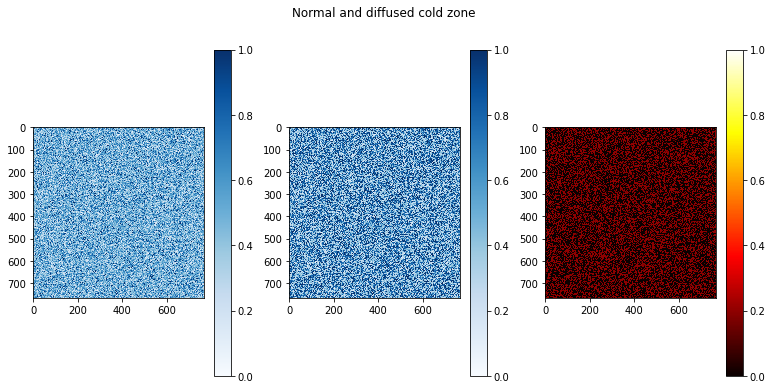

In [8]:
test_cold_zone = model_mixing.cold_zones[5]
diffused_cold_zone = model_mixing.diffuse_cold_zone(test_cold_zone, diffusion = 0.2, upper_bound = 0.5)
fig, axs = plt.subplots(figsize=(13, 6), ncols=3)
fig.suptitle('Normal and diffused cold zone')
pos = axs[0].imshow(test_cold_zone, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
fig.colorbar(pos, ax=axs[0])
pos = axs[1].imshow(diffused_cold_zone, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
fig.colorbar(pos, ax=axs[1])
pos = axs[2].imshow(abs(diffused_cold_zone - test_cold_zone), cmap='hot', interpolation='nearest', vmin=0, vmax=1)
fig.colorbar(pos, ax=axs[2])
plt.show()

# Let the mixing begin!
The mixing process is the fastest of this whole notebok, and should take just a few seconds on a slow CPU.

In [9]:
model_mixing.mix(1, cold_zone_diffusion = 0.2, upper_bound = 0.5, normalize_cold_zone = False)

# Testing the mixed model

This model seems to perform as good and in most cases better than a finetuned model in our tests, let's see what it does now!

In [10]:
prompt_test(model_manager)

Prompt: How are you?
Reply: park2<msg>Ry "I'm not sure, but I'm glad you're here. I'm glad you're here. I'm glad you're here. I'm glad you're here. I'm glad you're here. I'm glad you're here. I'm glad you're here. I'm glad you're here. I'm glad you're here. I'm glad you're
Reply [sampled]: park2<msg>Ry "Do you know what I'm talking about?"<|endoftext|>
----------
Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "I think he's funny."<|endoftext|>
Reply [sampled]: park2<msg>Ad "I think he is funny."<|endoftext|>
----------
Prompt: Oh my god, Adine. What is this?
Reply: adineapt<msg>Ad "Well, I'm not sure, but I'm afraid I don't."<d><scn>adineapt<msg>Ad "I see."<|endoftext|>
Reply [sampled]: o<msg>n "I know he is not the only one who has found the portal, but I know it is not the only one, but it is also the only one who has found the portal, who knows what he will do, but I'm not sure if he will do anything like that. I'm not sure if he will do anything like that, but I'm not sure

In [11]:
rp_test(model_manager)

Visit Lorem -> lorem<msg>Lo "Hey [player_name]! How are you?"<|endoftext|>
----------
Meet with Lorem -> lorem<msg>Lo "Hey, [player_name]!"<|endoftext|>
----------
Visit Adine -> adine<msg>Ad "Oh, I think I see it."<p><msg>c "What do you think of Adine?"<d><scn>adine<msg>Ad "I think she's funny."<|endoftext|>
----------
Fight Maverick -> o<msg>m "Maverick dodges Maverick's aim, and comes rushing towards me. I turned around and saw that Maverick was looking for me. I couldn't see where he was, but I saw that he was hitting me hard enough that I couldn't quite stop him. I couldn't see where he was, but I saw that he was hitting me in the face with his claws. I couldn't see where he was, but I saw that he was looking for Reza, and that I was right. I wasn
----------
Fight Adine -> adine<msg>m "Adine comes to mind. She's a big, ugly dragon, and wants to talk to you. I can tell you that."<d><scn>adine<msg>Ad "I'd rather not do that."<|endoftext|>
----------
Attack Adine -> adine<msg>m "Adin

In [12]:
target_model.save_pretrained(mixed_model_path)